# Dự đoán bệnh tiểu đường bằng hồi quy logistic




In [3]:
#Liên kết với drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Chèn các thư viện liên quan

In [1]:
# Chèn thư viện cần thiết
import pandas as pd
import numpy as np   
np.random.seed(42)   ## đầu ta nó gần giống nhau
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas_profiling as pp

from sklearn.model_selection import train_test_split, cross_val_score  #Chia tỉ lệ khung hình
from sklearn.metrics import jaccard_similarity_score #Kiểm tra độ chính xác
from sklearn.metrics import mean_squared_error #Phương pháp chữa lỗi bình phương
from sklearn.metrics import classification_report, confusion_matrix #pháp hoạ ma trận
from sklearn.preprocessing import StandardScaler

#models
#Đánh giá
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve


from sklearn.linear_model import LogisticRegression #Training model Hồi quy logistic
from sklearn.neighbors import KNeighborsClassifier #Training model KNN
from sklearn.svm import SVC

%matplotlib inline  
#Cảnh báo
from warnings import filterwarnings
filterwarnings("ignore")  ##  Để loại bỏ bất kỳ loại cảnh báo nào

###Lấy dữ liệu ở đây nè nhe!

In [4]:
# Truy cập dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NMT_VLUTE/Datasets/diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


###Một vài thuộc tính cơ sở

In [5]:
data.shape  ### Trả lại hình dạng của dữ liệu

(768, 9)

In [6]:
data.ndim  ### Trả về thứ nguyên n của dữ liệu

2

In [7]:
data.size   ### Trả về độ lớn của dữ liệu

6912

In [8]:
data.isna().sum() ### Trả về tổng của tất cả các giá trị na

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
data.info() ### Đưa ra bản tóm tắt ngắn gọn về DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
data.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [16]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Kết quả trực quan thu được

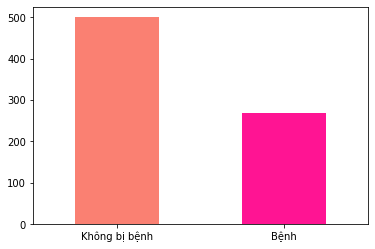

In [13]:
data["Outcome"].value_counts()
data["Outcome"].value_counts().plot(kind="bar",color=["salmon","deeppink"])
plt.xticks(np.arange(2), ('Không bị bệnh', 'Bệnh'),rotation=0);

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Lấy dữ liệu dựa vào chỉ số

### Chỉ số Glucose

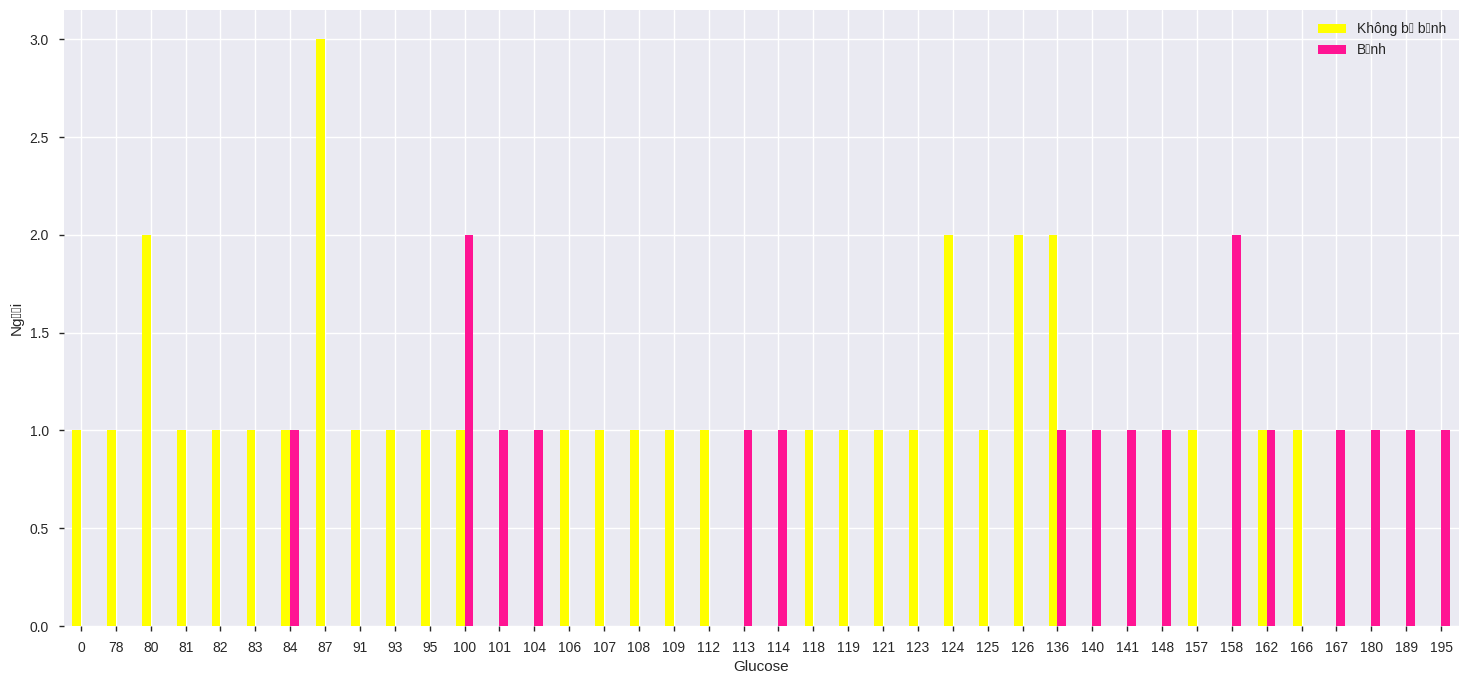

In [19]:
pd.crosstab(data.Glucose[::15],data.Outcome).plot(kind="bar",figsize=(18,8),color=["yellow","deeppink"])
plt.ylabel("Người");
plt.xticks(rotation=0);
plt.legend(['Không bị bệnh', 'Bệnh']);

###Chỉ số huyết áp

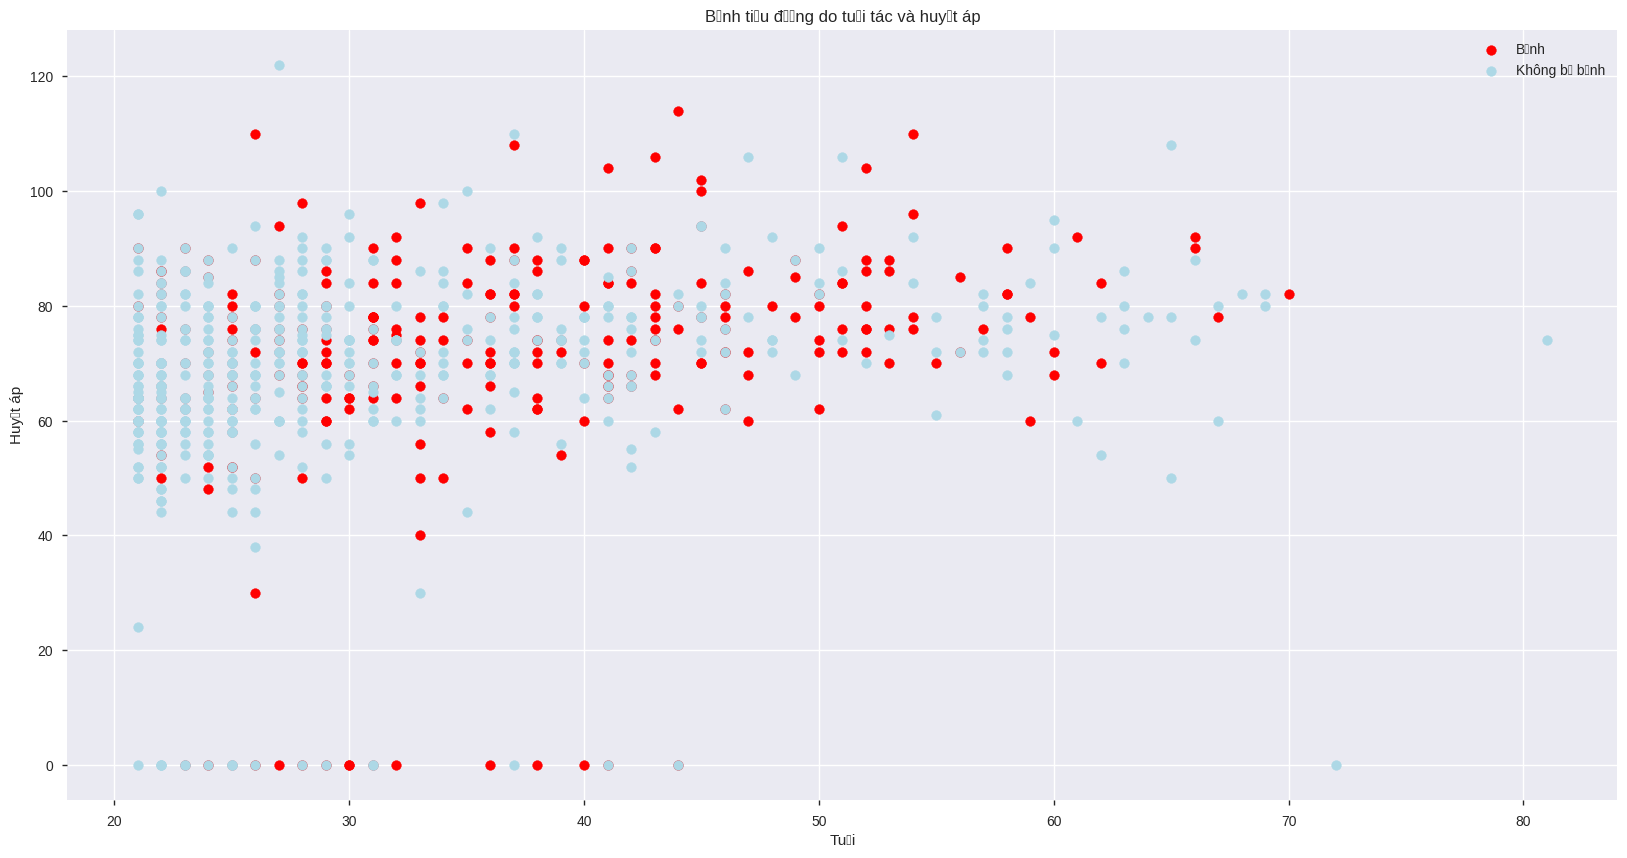

In [20]:
plt.figure(figsize=(20,10))

# Tích cực
plt.scatter(data.Age[data.Outcome==1],data.BloodPressure[data.Outcome==1],c="red");

# Tiêu cực
plt.scatter(data.Age[data.Outcome==0],data.BloodPressure[data.Outcome==0],c="lightblue");

# Add some helpful info
plt.title("Bệnh tiểu đường do tuổi tác và huyết áp")
plt.xlabel("Tuổi")
plt.ylabel("Huyết áp")
plt.legend(["Bệnh","Không bị bệnh"]);

### Ghép nối khung dữ liệu

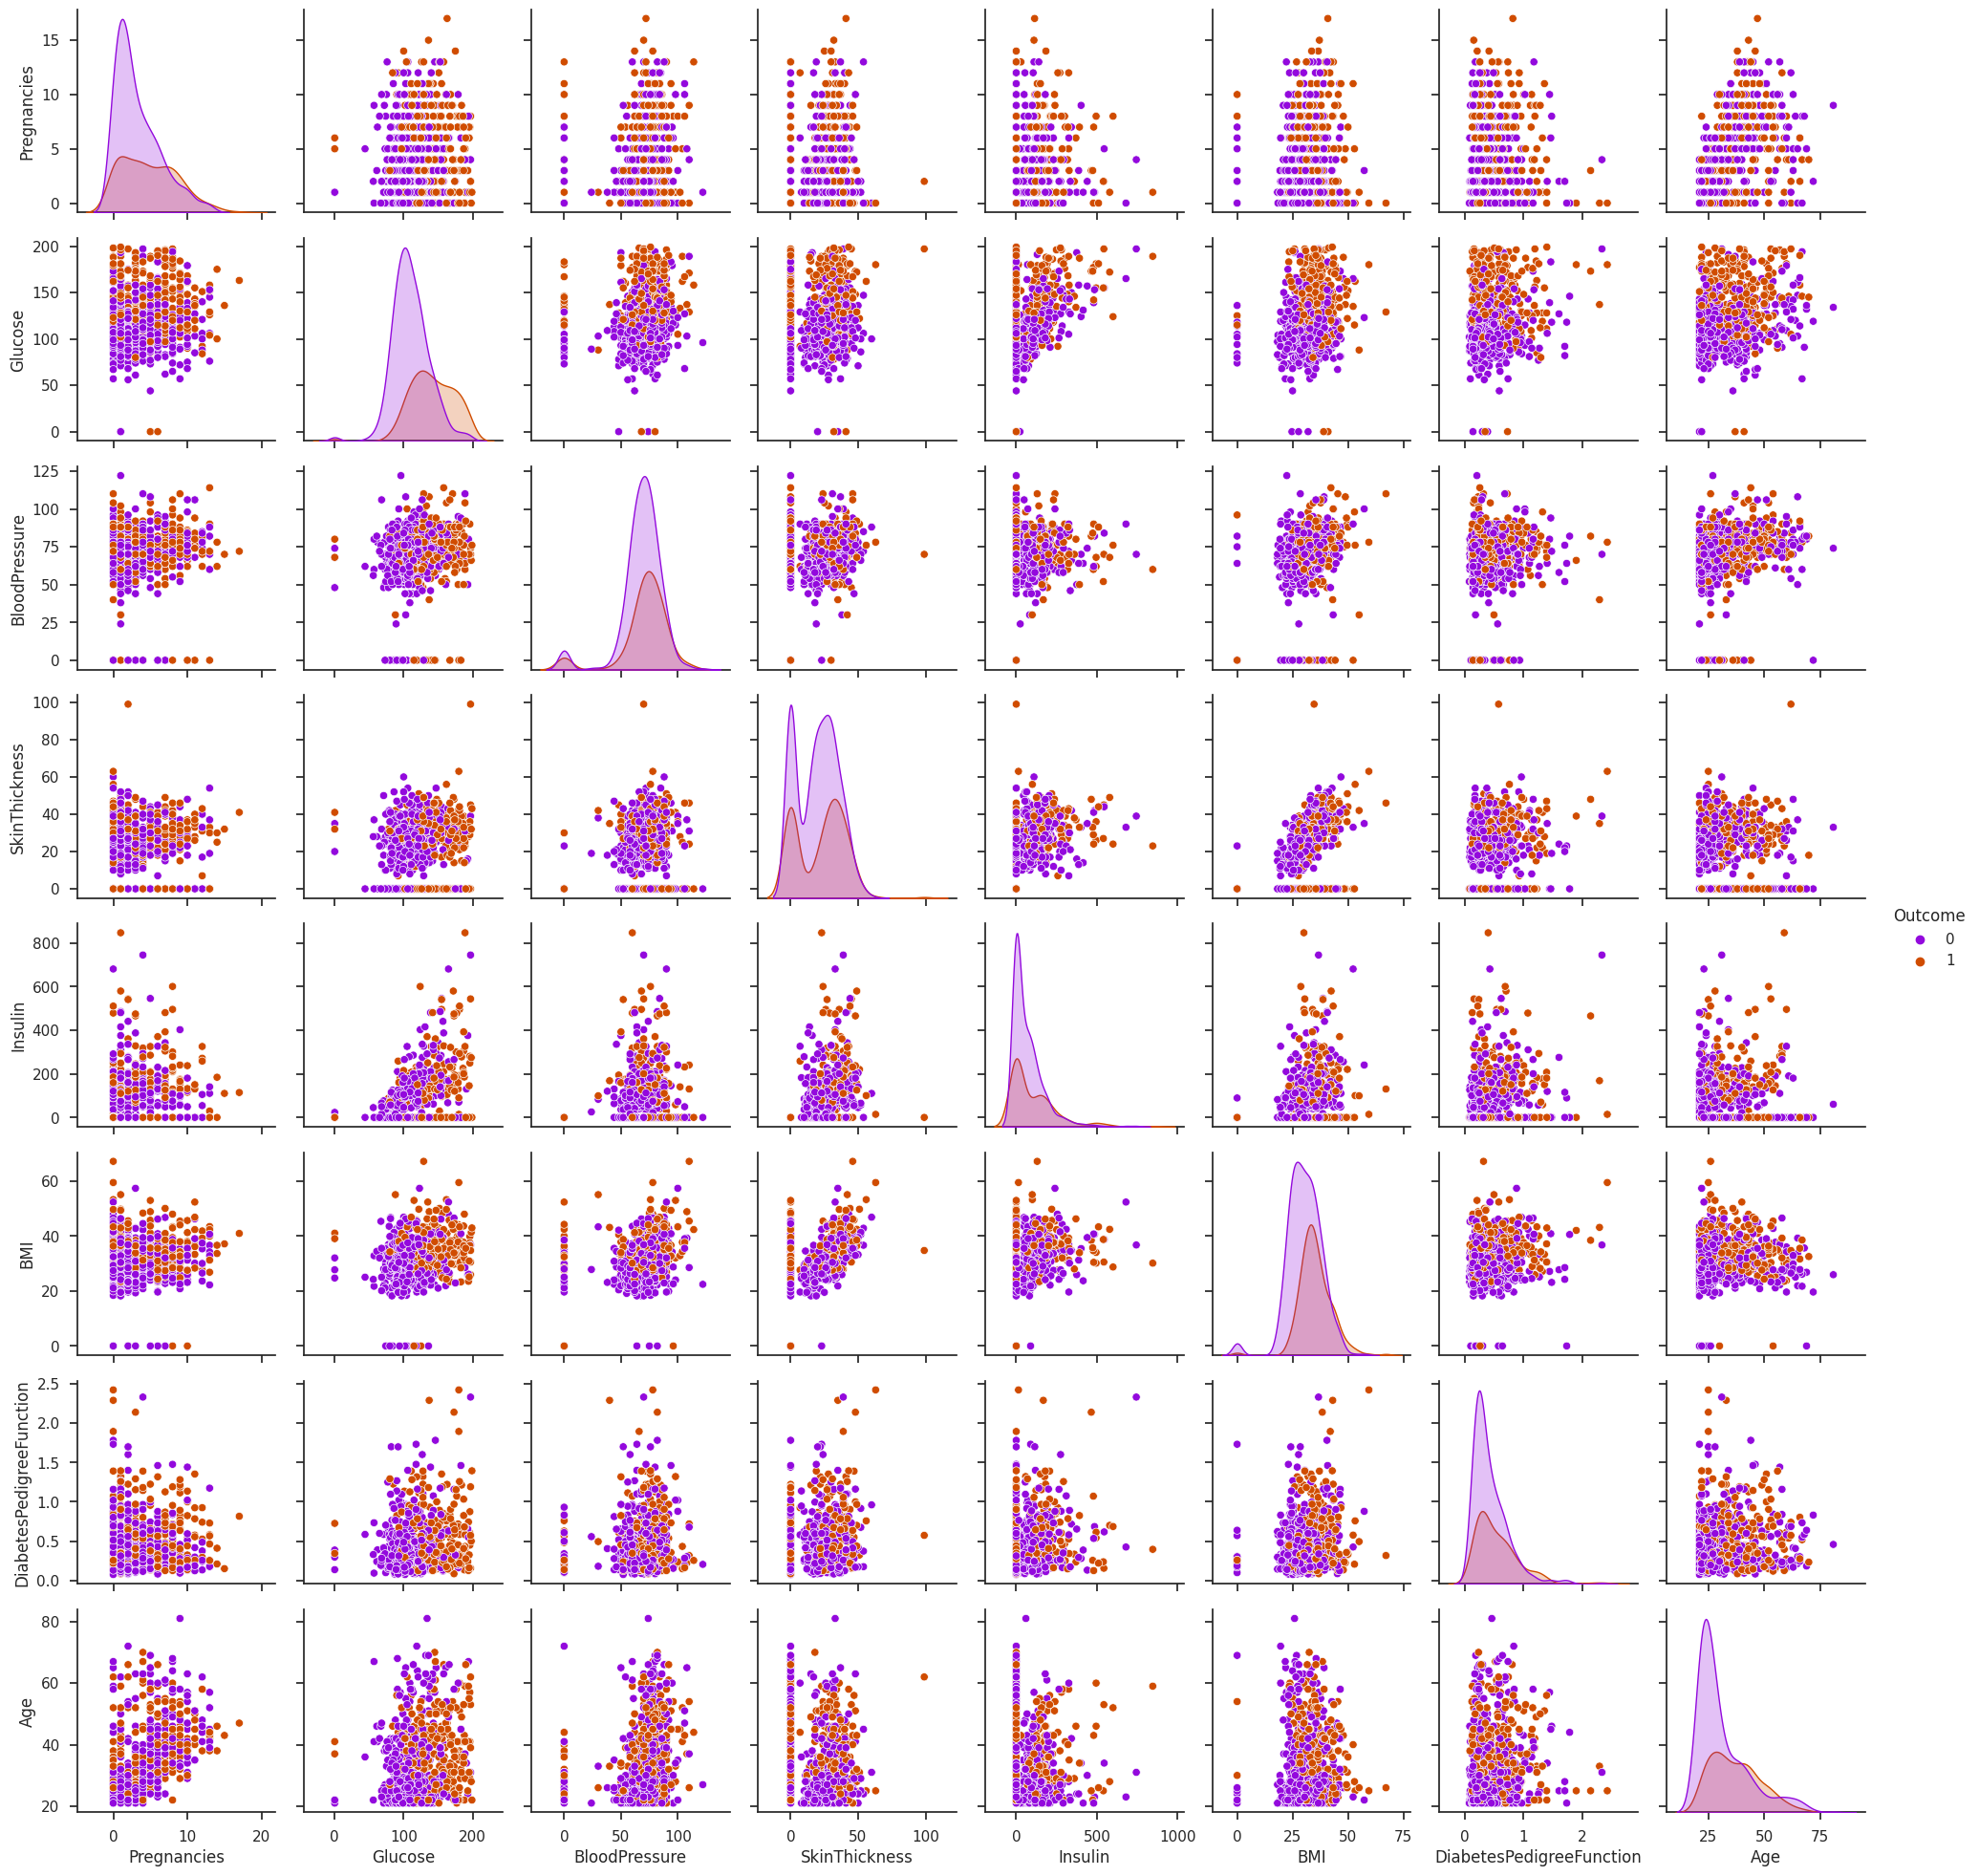

In [21]:
# sns.pairplot(data)
sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');

### Biểu đồ của tất cả các màu khi Kết quả là 1 (bị Tiểu đường)

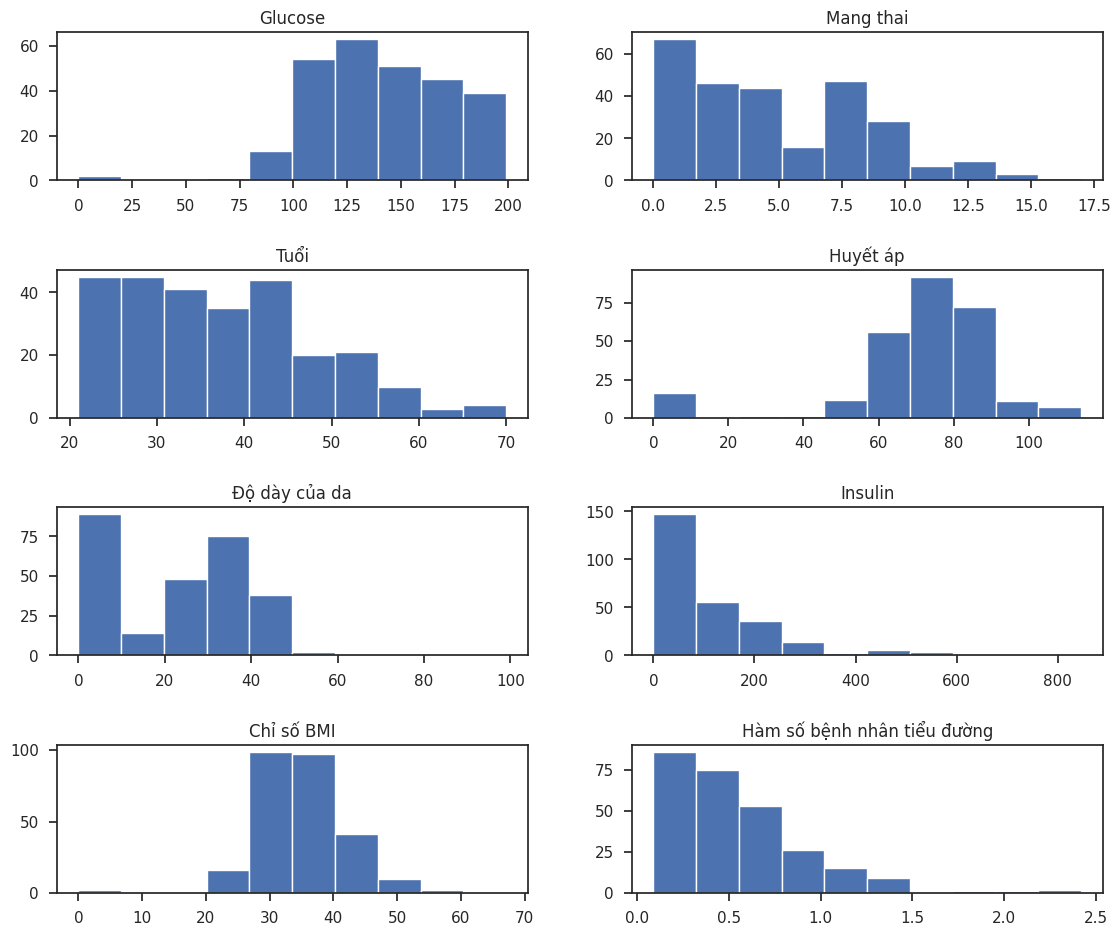

In [22]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
fig.tight_layout(pad=3.0)
ax[0,0].set_title('Glucose')
ax[0,0].hist(data.Glucose[data.Outcome==1]);
ax[0,1].set_title('Mang thai')
ax[0,1].hist(data.Pregnancies[data.Outcome==1]);
ax[1,0].set_title('Tuổi')
ax[1,0].hist(data.Age[data.Outcome==1]);
ax[1,1].set_title('Huyết áp')
ax[1,1].hist(data.BloodPressure[data.Outcome==1]);
ax[2,0].set_title('Độ dày của da')
ax[2,0].hist(data.SkinThickness[data.Outcome==1]);
ax[2,1].set_title('Insulin')
ax[2,1].hist(data.Insulin[data.Outcome==1]);
ax[3,0].set_title('Chỉ số BMI')
ax[3,0].hist(data.BMI[data.Outcome==1]);
ax[3,1].set_title('Hàm số bệnh nhân tiểu đường')
ax[3,1].hist(data.DiabetesPedigreeFunction[data.Outcome==1]);

## Ma trận tương quan giữa các cột

### Nó cho thấy mối tương quan (tích cực, phủ định) giữa các cột khác nhau (chỉ các cột giá trị nguyên)

In [23]:
corr_matrix = data.corr()

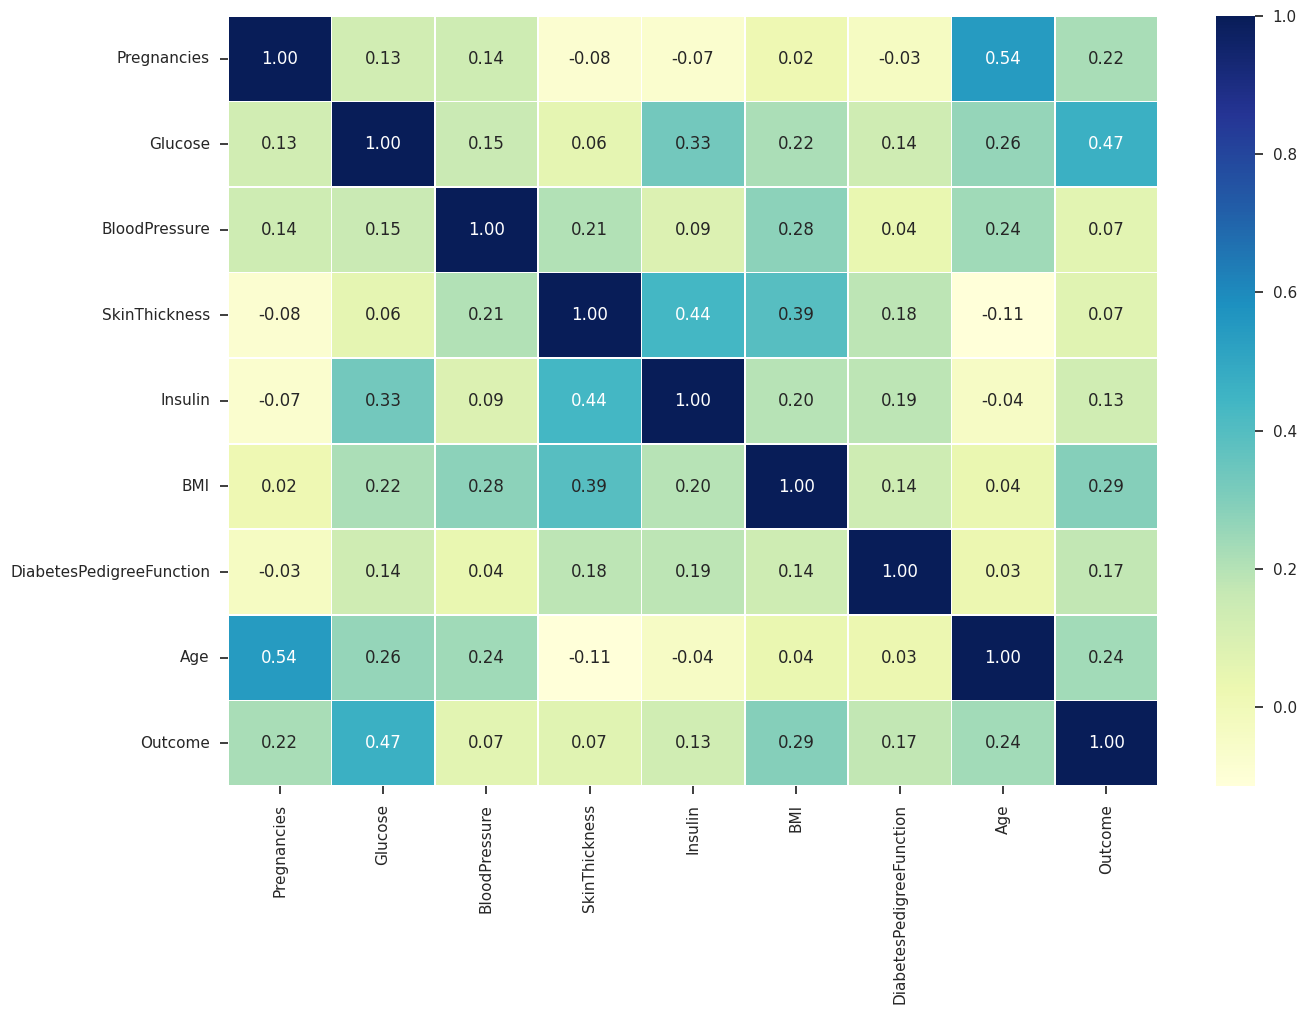

In [24]:
corr_matrix = data.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                linewidth=0.5,
                fmt=".2f",
                cmap="YlGnBu")

##Mô hình hoá

In [27]:
#Dữ liệu ngẫu nhiên
data.sample(frac=1)

#Chia nhỏ dữ liệu
X = data.drop("Outcome",axis=1)
y = data["Outcome"]
X_train,X_test,y_train,y_test =  train_test_split(X, y, test_size=0.2)

In [28]:
(len(X_train),len(X_test))

(614, 154)

##Thử các phương pháp khác nhau:
        1.Phương pháp hồi quy Logistic 
        2.Phương pháp KNN
        3.Phương pháp RFC (Random Forest Classifier)
        4.Phương pháp SVM (Support Vector Machine)

### 1. Hồi quy Logistic


In [29]:
log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train,y_train);
## Đánh giá mô hình
log_reg = log_reg.score(X_test,y_test)

### 2.Phương thức KNN

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train);
## Đánh giá mô hình
knn = knn.score(X_test,y_test)

### 3. Mô hình RFC (Random forest classifier)


In [31]:
clf= RandomForestClassifier()
clf.fit(X_train,y_train);
## Đánh giá mô hình
clf = clf.score(X_test,y_test)

### 4. Mô hình SVM (Support Vector Machine)


In [32]:
svm = SVC()
svm.fit(X_train,y_train)
svm = svm.score(X_test,y_test)

### ĐÁNH GIÁ CẢ 4 MÔ HÌNH

In [33]:
model_compare = pd.DataFrame({"Hồi quy Logistic":log_reg,
                            "Hàng xóm gần nhất KNN":knn,
                            "Mô hình RFC Random Forest Classifier":clf,
                           "Mô hình SVM Support Vector Machine":svm,
                            },index=["Tỉ lệ chính xác"])

In [34]:
## Xuất kết quả
model_compare

,Hồi quy Logistic,Hàng xóm gần nhất KNN,Mô hình RFC Random Forest Classifier,Mô hình SVM Support Vector Machine
Tỉ lệ chính xác,0.831169,0.779221,0.785714,0.811688


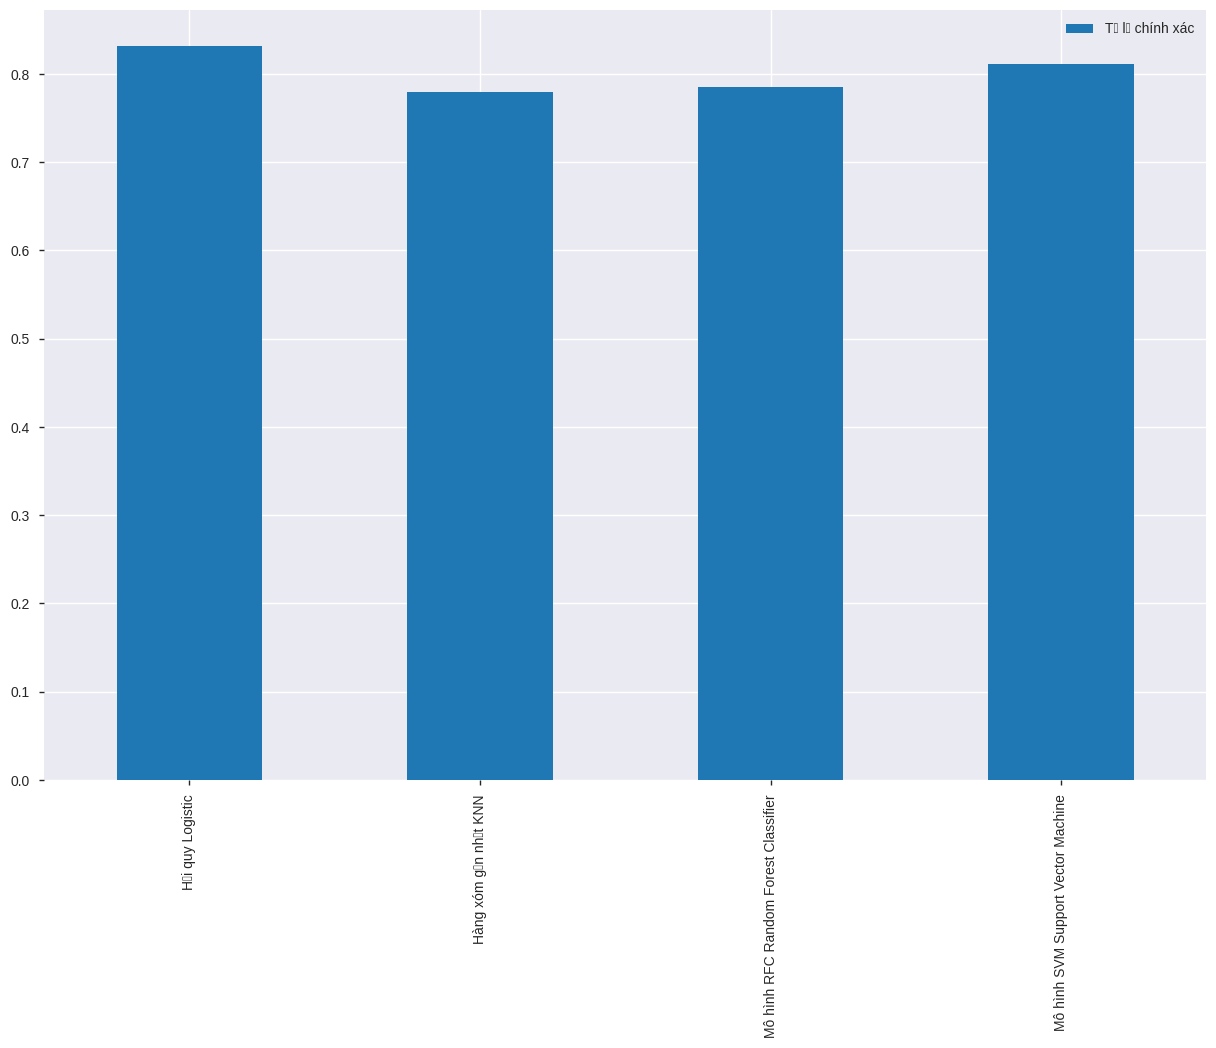

In [35]:
##Sơ đồ
model_compare.T.plot.bar(figsize=(15,10));

## Điều chỉnh SIÊU tham số bằng cv Tìm kiếm ngẫu nhiên

## Tạo lưới siêu tham số

In [36]:
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [37]:
# Điều chỉnh hậu cần
np.random.seed(42)

# Thiết lập tìm kiếm siêu tham số ngẫu nhiên cho Hồi quy Logistic
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

#Phù hợp với mô hình tìm kiếm siêu tham số ngẫu nhiên cho Hồi quy Logistic
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C':...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+0

### Sử dụng Grid Search CV Logistic Regression

In [38]:
log_reg_grid = {'C': np.logspace(-4,4,30),
               "solver":["liblinear"]}

#Thiết lập grid cv
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

#phù hợp với search cv grid
gs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 1.8...
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5

In [39]:
gs_log_reg.score(X_test,y_test)

0.8376623376623377

In [40]:
gs_log_reg.score(X_test,y_test) - log_reg

0.00649350649350644

## Mô hình tốt nhất là hồi quy logistic với độ chính xác 83%

### Đánh giá mô hình

In [41]:
y_preds = gs_log_reg.predict(X_test)
y_preds

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [42]:
np.array(y_test)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

### Biểu đồ đường cong ROC

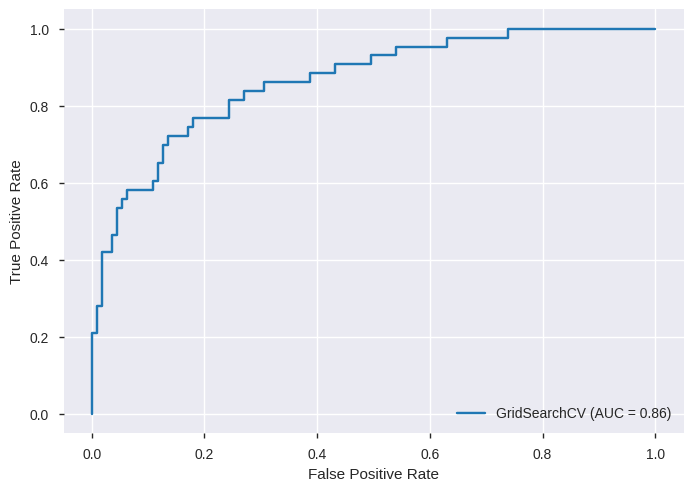

In [43]:
plot_roc_curve(gs_log_reg,X_test,y_test)

### Ma trận Confusion

In [44]:
print(confusion_matrix(y_test,y_preds))

[[105   6]
 [ 19  24]]


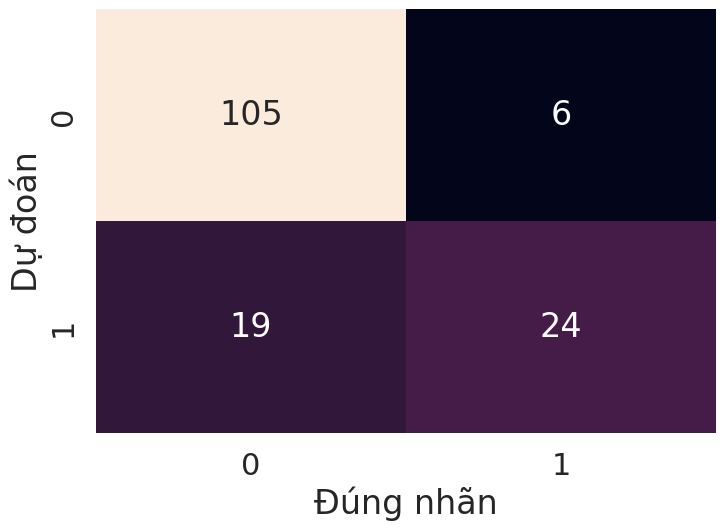

In [45]:
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(y_test,y_preds), annot=True,cbar=False, fmt='g')
plt.xlabel("Đúng nhãn")
plt.ylabel("Dự đoán");

In [46]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89       111
           1       0.80      0.56      0.66        43

    accuracy                           0.84       154
   macro avg       0.82      0.75      0.78       154
weighted avg       0.83      0.84      0.83       154



### Kiểm tra siêu tham số tốt nhất

In [47]:
gs_log_reg.best_params_

{'C': 2.592943797404667, 'solver': 'liblinear'}

### Tạo bộ phân loại mới với các tham số tốt nhất

In [48]:
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

### Độ chính xác accuracy

In [49]:
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=10,
                         scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

0.75

### Độ chính xác precision

In [50]:
cv_precision = cross_val_score(clf,
                         X,
                         y,
                         cv=10,
                         scoring="precision")
cv_precision=np.mean(cv_precision)
cv_precision

0.7142036215119739

### xác thực chéo Recall

In [51]:
cv_recall = cross_val_score(clf,
                         X,
                         y,
                         cv=10,
                         scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.48091168091168085

### Điểm f1 được xác thực chéo

In [52]:
cv_f1 = cross_val_score(clf,
                         X,
                         y,
                         cv=10,
                         scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.569372018074834

### Hình ảnh hóa

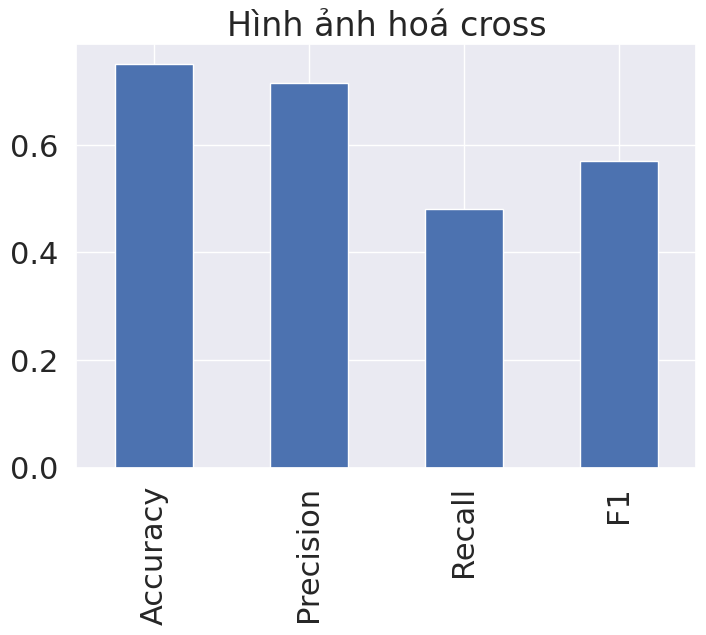

In [53]:
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])

cv_metrics.T.plot.bar(title="Hình ảnh hoá cross",
                      legend=False);

In [54]:
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

clf.fit(X_train, y_train);
clf.coef_

array([[ 9.97139379e-02,  1.98807433e-02, -2.16058281e-02,
         1.68049051e-03, -2.78852839e-04,  2.44470260e-02,
         3.64789703e-01, -2.00367937e-03]])

In [55]:
feature_dict = dict(zip(data.columns, list(clf.coef_[0])))
feature_dict

{'Age': -0.002003679368049672,
 'BMI': 0.02444702597368331,
 'BloodPressure': -0.021605828059518647,
 'DiabetesPedigreeFunction': 0.3647897033527383,
 'Glucose': 0.019880743287976486,
 'Insulin': -0.0002788528388916387,
 'Pregnancies': 0.09971393793239663,
 'SkinThickness': 0.0016804905143428283}

### Hình ảnh hoá 

In [ ]:
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Tầm quan trọng của tính năng", legend=False);

## LƯU TỆP

In [ ]:
import pickle
pickle.dump(gs_log_reg, open("/content/drive/MyDrive/Colab Notebooks/NMT_VLUTE/pickle/Diabetes.pkl", "wb"))

In [ ]:
loaded_model = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/NMT_VLUTE/pickle/Diabetes.pkl", "rb"))
loaded_model.predict(X_test)
loaded_model.score(X_test,y_test)

0.8376623376623377

## TẢI THÊM DỮ LIỆU MỚI

In [ ]:
X_test.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
20,3,126,88,41,235,39.3,0.704,27


### Nhập phép thử

In [ ]:
Pregnancies = input()
Glucose = input()
BloodPressure = input()
SkinThickness = input()
Insulin = input()
BMI = input()
DiabetesPedigreeFunction = input()
Age = input()

1
134
140
22
24.6
34.2
0.54
27


In [ ]:
row_df = pd.DataFrame([pd.Series([Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI ,DiabetesPedigreeFunction ,Age])])
row_df

,0,1,2,3,4,5,6,7
0,1,134,140,22,24.6,34.2,0.54,27


In [ ]:
prob = loaded_model.predict_proba(row_df)[0][1]
print(f"Xác suất bạn mắc bệnh Tiểu đường là {prob}")

Xác suất bạn mắc bệnh Tiểu đường là 0.1974541261879753


In [ ]:
loaded_model.predict(row_df)[0]

0

### Thêm dữ liệu vào


In [ ]:
row_df.to_csv('/content/drive/MyDrive/Colab Notebooks/NMT_VLUTE/pickle/Diabetes.pkl', mode='a', header=False)